In [1]:
from module import decomposition
from module import dickey_fuller
from module import arima_endog
from module import arima_exog
from module import rmse_cv
from module import lasso_reg


import pandas_datareader.data as web
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy import hstack
import warnings
import os
from fredapi import Fred
warnings.filterwarnings('ignore')

import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
import pmdarima as pm
from pmdarima import model_selection

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

%matplotlib inline
%load_ext autoreload
%autoreload

Using TensorFlow backend.


### Set Datetime

In [2]:
start = datetime(2000,2,1)
end = datetime(2020,1,31)

## Gather Endogenous Data 

In [3]:
MAA = web.DataReader('MAA', 'av-daily', start = start, end = end, api_key = 'Y8YQFOIVHPA381U4')
MAA = MAA.copy()
MAA.index = pd.to_datetime(MAA.index)
MAA = MAA.resample('MS').mean()
MAA['mid'] = (MAA['high']+MAA['low'])/2
MAA.drop(labels = ['high', 'low', 'open', 'close', 'volume'], axis = 1, inplace = True)

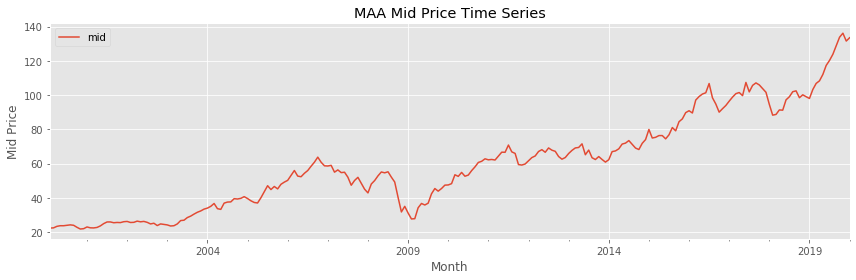

In [5]:
plt.style.use('ggplot')
MAA.plot(figsize = (12,4))
plt.xlabel('Month')
plt.ylabel('Mid Price')
plt.title('MAA Mid Price Time Series')
plt.tight_layout()
plt.show();

## Perform Decomposition of Time Series

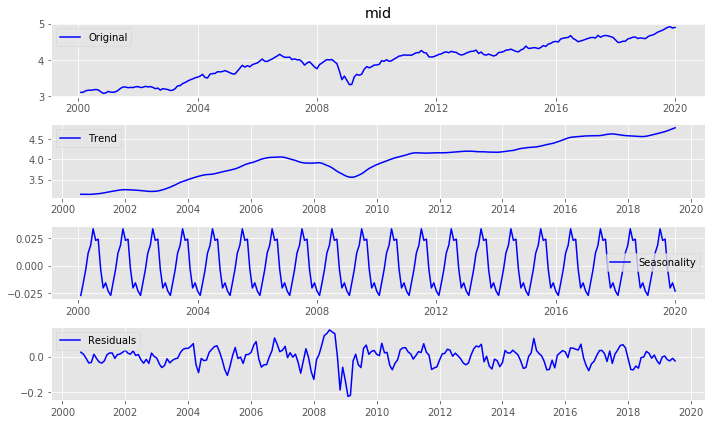

In [5]:
decomposition(MAA)

In [6]:
MAA_diff = MAA.diff(periods = 1).dropna()

In [7]:
dickey_fuller(MAA_diff)

The series passes the Dickey Fuller Test for Stationarity. P-Value = 0.01840321381636149


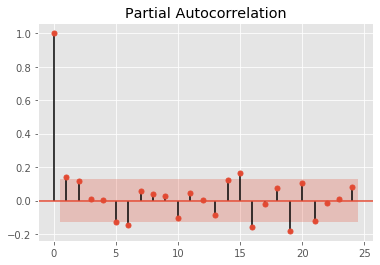

In [8]:
plot_pacf(MAA_diff);

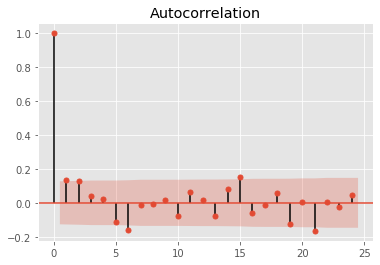

In [9]:
plot_acf(MAA_diff);

In [32]:
parameters = (9,1,5)
seasonal_parameters = (9,1,5,12)

## Train Test Split

In [33]:
MAA_train = MAA[:'2017']
MAA_test = MAA['2018':]

## SARIMAX Model (No Exogenous Variables)

Summary:                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  215
Model:             SARIMAX(9, 1, 5)x(9, 1, 5, 12)   Log Likelihood                -222.193
Date:                            Mon, 10 Feb 2020   AIC                            504.387
Time:                                    16:13:24   BIC                            577.666
Sample:                                02-01-2000   HQIC                           533.862
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0003      0.002      0.189      0.850      -0.003       0.003
ar.L1          0.1388     

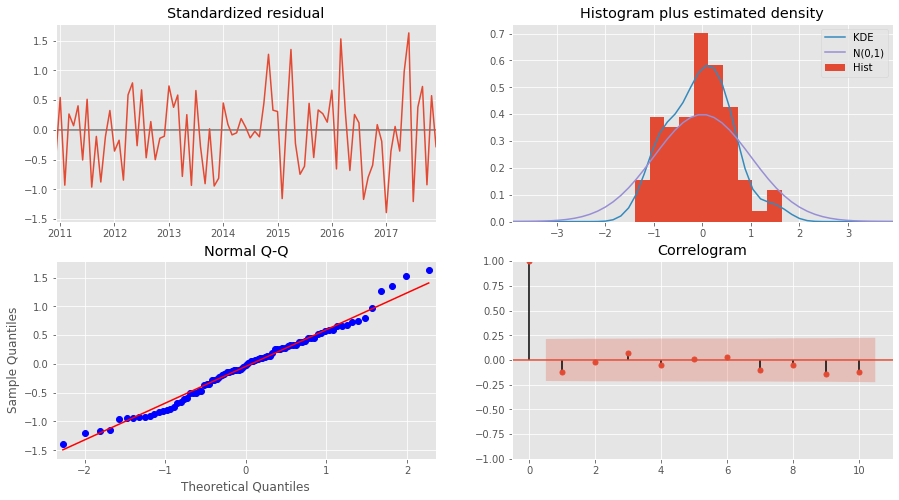

--------------------------------------------------------------------------------------------------------------------------------------------------------------
 
Predictions vs. Observed: 
 


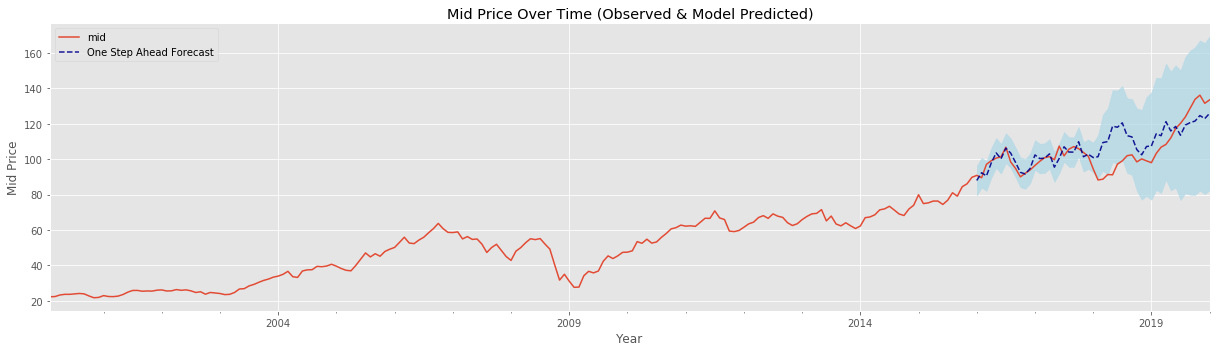

In [34]:
arima_endog(MAA_train, MAA, parameters, seasonal_parameters)

## Gather Exogenous Variables

In [35]:
MAA_rates = pd.read_csv('data/MAA_rates.csv', index_col = 'date')

### Perform Lasso Regression

The R-score of the Lasso Regression is: 0.9878973612297546

usd1mtd156n      -0.000000e+00
mortgage30us      0.000000e+00
mortgage15us      0.000000e+00
dcpf3m           -0.000000e+00
cpn3m            -0.000000e+00
dcpf1m           -0.000000e+00
aaa               2.343652e+00
baa               0.000000e+00
dff              -4.289260e-02
flexsc           -0.000000e+00
t10y2y            0.000000e+00
t10y3m            0.000000e+00
tedrate          -0.000000e+00
t10yff            6.728929e-01
t5yff             0.000000e+00
tb6smffm          0.000000e+00
usd3mtd156n      -0.000000e+00
usd12md156n       0.000000e+00
eur1wkd156n       0.000000e+00
mprime           -0.000000e+00
tb3ms            -0.000000e+00
dtb6             -0.000000e+00
dgs10            -0.000000e+00
dgs3mo           -0.000000e+00
dexuseu          -0.000000e+00
dexchus           0.000000e+00
dexusuk          -0.000000e+00
dexsius           0.000000e+00
nasdaqcom         3.751377e-03
willreitind       9.870266e-03
willlrgcap

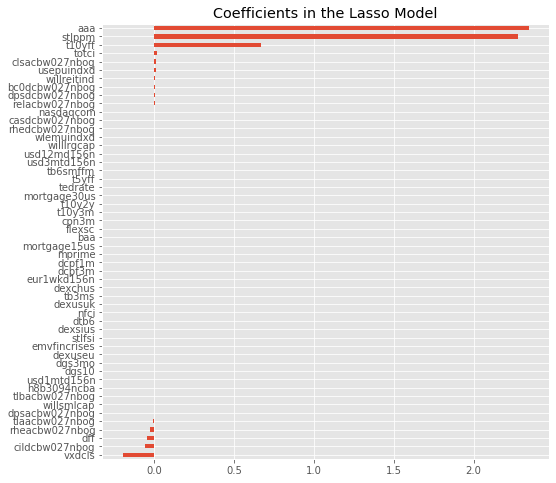

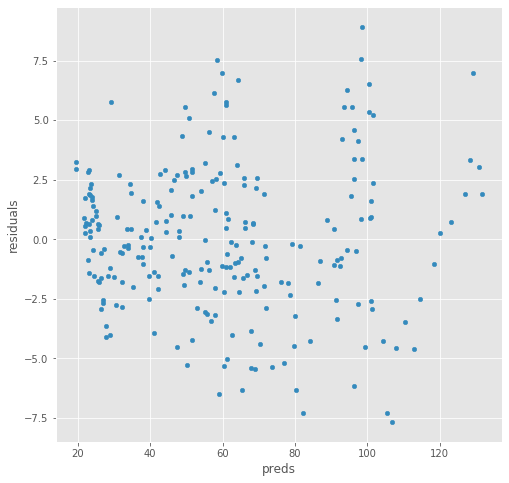

In [36]:
lasso_reg(MAA_rates)

### Select significant exogenous features from Lasso Regression

In [44]:
MAA_rates_train = MAA_rates[:'2018']
MAA_rates_test = MAA_rates['2018':]

In [45]:
exog_train = MAA_rates_train[['aaa', 'stlppm', 't10yff', 'vxdcls']]

In [46]:
exog_test = MAA_rates_test[['aaa', 'stlppm', 't10yff', 'vxdcls']]

In [47]:
exog_train.shape, exog_test.shape

((215, 4), (25, 4))

Summary:                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  215
Model:             SARIMAX(9, 1, 5)x(9, 1, 5, 12)   Log Likelihood                -211.356
Date:                            Mon, 10 Feb 2020   AIC                            490.712
Time:                                    16:25:39   BIC                            573.762
Sample:                                02-01-2000   HQIC                           524.117
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0006      0.003      0.227      0.821      -0.005       0.006
aaa           -3.0174     

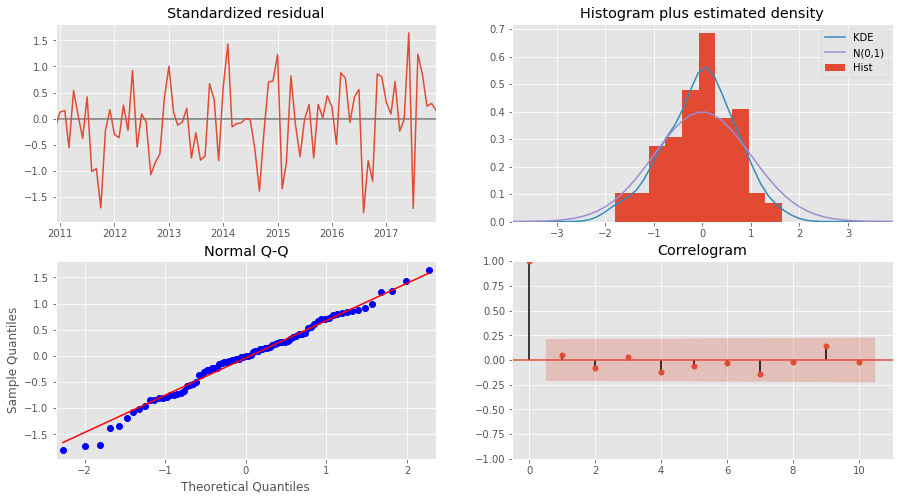

In [48]:
arima_model = sm.tsa.statespace.SARIMAX(MAA_train,
                                        exog = exog_train,
                                        order = parameters,
                                        seasonal_order = seasonal_parameters,
                                        enforce_stationarity = False,
                                        enforce_invertability = False,
                                        trend = 't')
results = arima_model.fit()
print(f'Summary: {results.summary()}')
print()
print('Diagnostics: ')
results.plot_diagnostics(figsize = (15,8))
plt.show()

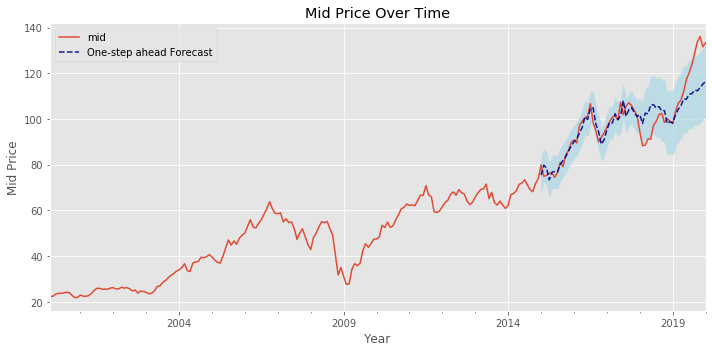

In [52]:
predictions = results.get_prediction(start = pd.to_datetime('2015-01-01'), end = pd.to_datetime('2020-01-01'), dynamic=False, exog = exog_test)
pred_conf = predictions.conf_int()
    
#Plot observed values
ax = MAA['2000-02-01':].plot(label='observed', figsize = (10,5))

#Plot predicted values
predictions.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9, color = 'darkblue', style = '--')

#Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='lightblue', alpha=.7)

#Set axes labels
ax.set_xlabel('Year')
ax.set_ylabel('Mid Price')
plt.legend(loc = 'best')
plt.title(f'Mid Price Over Time')
plt.tight_layout()
plt.show()
    